# Cryptocurrency using Multi-State LSTM
In this notebook, we analyze cryptocurrency datasets and define a problem to solve using multi-state LSTM

## Contents
* Data Understanding
* Data Cleaning
* Problem Definition
* Data Preprocessing
* Modeling
* Evaluation

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import deque
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

### Data Understanding

There are four currencies and each currency has 6 features such as time, low, high, open, close and volume

In [2]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

In [3]:
sample = pd.read_csv('data/LTC-USD.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])

In [4]:
sample.head()

,time,low,high,open,close,volume
0,1528968660,96.580002,96.589996,96.589996,96.580002,9.647200
1,1528968720,96.449997,96.669998,96.589996,96.660004,314.387024
2,1528968780,96.470001,96.570000,96.570000,96.570000,77.129799
3,1528968840,96.449997,96.570000,96.570000,96.500000,7.216067
4,1528968900,96.279999,96.540001,96.500000,96.389999,524.539978


In [9]:
sample.shape

(101883, 6)

In [7]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101883 entries, 0 to 101882
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    101883 non-null  int64  
 1   low     101883 non-null  float64
 2   high    101883 non-null  float64
 3   open    101883 non-null  float64
 4   close   101883 non-null  float64
 5   volume  101883 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.7 MB


In [8]:
sample.nunique()

time      101883
low         4513
high        4493
open        4534
close       4551
volume    101017
dtype: int64

In [10]:
del sample

### Data Cleaning
* Joining 4 datasets
* Handling NaN values

Here we define a new dataframe and join 4 datasets into 1 dataset on time feature

In [11]:
main_dataframe = pd.DataFrame()

In [12]:
for c in currencies:
    dataset = 'data/' + c + '.csv'
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])
    df.rename(columns={'close': c + '_close', 'volume': c + '_volume'}, inplace=True)
    df.set_index('time', inplace=True)
    df = df[[c + '_close', c + '_volume']]
    if len(main_dataframe) == 0:
        main_dataframe = df
    else:
        main_dataframe = main_dataframe.join(df)

In [13]:
main_dataframe.head()

,BCH-USD_close,BCH-USD_volume,BTC-USD_close,BTC-USD_volume,ETH-USD_close,ETH-USD_volume,LTC-USD_close,LTC-USD_volume
time,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


In [14]:
main_dataframe.shape

(92225, 8)

There are some NaN values because of join query

In [15]:
main_dataframe.isnull().sum()

BCH-USD_close        0
BCH-USD_volume       0
BTC-USD_close     5122
BTC-USD_volume    5122
ETH-USD_close      195
ETH-USD_volume     195
LTC-USD_close      836
LTC-USD_volume     836
dtype: int64

In [6]:
main_dataframe.fillna(method='ffill', inplace=True)

In [7]:
main_dataframe.isnull().sum()

BCH-USD_close     0
BCH-USD_volume    0
BTC-USD_close     0
BTC-USD_volume    0
ETH-USD_close     1
ETH-USD_volume    1
LTC-USD_close     0
LTC-USD_volume    0
dtype: int64

In [9]:
main_dataframe.fillna(method='bfill', inplace=True)

In [10]:
main_dataframe.head()

,BCH-USD_close,BCH-USD_volume,BTC-USD_close,BTC-USD_volume,ETH-USD_close,ETH-USD_volume,LTC-USD_close,LTC-USD_volume
time,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,486.01001,26.019083,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


In [11]:
main_dataframe.isnull().sum()

BCH-USD_close     0
BCH-USD_volume    0
BTC-USD_close     0
BTC-USD_volume    0
ETH-USD_close     0
ETH-USD_volume    0
LTC-USD_close     0
LTC-USD_volume    0
dtype: int64

---
### Problem Definition

We have 2 columns for each currency, close and volume and we create a new column named "future" to store the LTC-USD_close value after 3 days.

**Problem:** Is it beneficial to buy LTC currency or not?

In [12]:
main_dataframe['future'] = main_dataframe['LTC-USD_close'].shift(-3)

In [13]:
main_dataframe.head()

,BCH-USD_close,BCH-USD_volume,BTC-USD_close,BTC-USD_volume,ETH-USD_close,ETH-USD_volume,LTC-USD_close,LTC-USD_volume,future
time,,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,486.01001,26.019083,96.580002,9.647200,96.500000
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,96.389999
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,96.519997
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,96.440002
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,96.470001


Creating target

In [14]:
def compare(current, future):
    if future > current:
        return 1
    else:
        return 0
main_dataframe['target'] = list(map(compare, main_dataframe['LTC-USD_close'], main_dataframe['future']))

In [15]:
main_dataframe.head()

,BCH-USD_close,BCH-USD_volume,BTC-USD_close,BTC-USD_volume,ETH-USD_close,ETH-USD_volume,LTC-USD_close,LTC-USD_volume,future,target
time,,,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,486.01001,26.019083,96.580002,9.647200,96.500000,0
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,96.389999,0
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,96.519997,0
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,96.440002,0
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,96.470001,1


### Data Preprocessing
* Train-test split
* Data to sequence
* Percentage change
* Min-max scaling
* Under-sampling

In [16]:
times = sorted(main_dataframe.index.values)

In [17]:
len(times)

92225

We use the last 10 percent of data for testing and others for training

In [19]:
last_10pct = sorted(main_dataframe.index.values)[-int(0.1 * len(times))]

In [21]:
main_dataframe_test = main_dataframe[(main_dataframe.index >= last_10pct)]
main_dataframe_train = main_dataframe[(main_dataframe.index < last_10pct)]

In [22]:
len(main_dataframe_test)

9222

In [23]:
len(main_dataframe_train)

83003

The main preprocessor function for:
- Dividing the data into sequences
- Scaling
- Undersampling

In [16]:
seq = 30

In [26]:
def preprocess_main_dataframe(df):
    # Scaling
    df = df.drop('future', axis=1)
    for col in df.columns:
        if col != 'target':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    df.dropna(inplace=True)
    
    # Sequences
    sequences = []
    prev_days = deque(maxlen=seq)
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == seq:
            sequences.append([np.array(prev_days), i[-1]])
    random.shuffle(sequences)
    
    # Under-sampling
    buys = []
    sells = []
    for seq, target in sequences:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])
    random.shuffle(buys)
    random.shuffle(sells)
    lower = min(len(buys), len(sells))
    buys = buys[:lower]
    sells = sells[:lower]
    sequential_data = buys + sells
    random.shuffle(sequential_data)
    X = []
    y = []
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [27]:
train_X, train_y = preprocess_main_dataframe(main_dataframe_train)

In [28]:
train_X.shape

(71030, 30, 8)

In [29]:
train_y.shape

(71030,)

In [30]:
np.unique(train_y, return_counts=True)

(array([0., 1.]), array([35515, 35515]))

In [31]:
test_X, test_y = preprocess_main_dataframe(main_dataframe_test)

In [42]:
test_X.shape

(7840, 30, 8)

### Modeling

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq, 8), return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           70144     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 64)           256       
 hNormalization)                                      

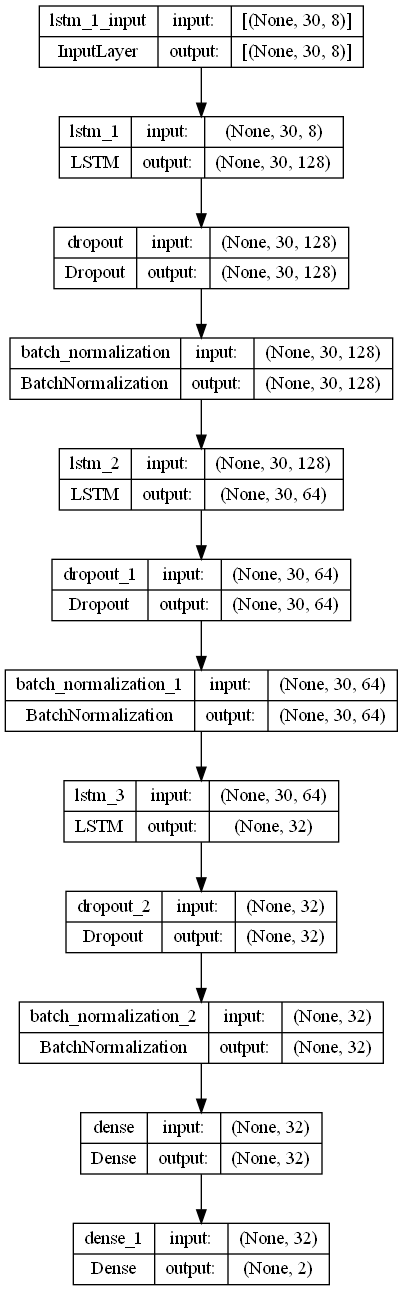

In [24]:
plot_model(model, show_shapes=True)

In [26]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [37]:
history = model.fit(train_X, train_y, batch_size=100, epochs=100,
                    validation_data=(test_X, test_y), callbacks=[checkpoint_callback])

Epoch 1/100
711/711 [==============================] - 61s 86ms/step - loss: 0.7038 - accuracy: 0.5161 - val_loss: 0.6893 - val_accuracy: 0.5258
Epoch 2/100
711/711 [==============================] - 57s 80ms/step - loss: 0.6910 - accuracy: 0.5336 - val_loss: 0.6855 - val_accuracy: 0.5490
Epoch 3/100
711/711 [==============================] - 57s 80ms/step - loss: 0.6878 - accuracy: 0.5446 - val_loss: 0.6851 - val_accuracy: 0.5528
Epoch 4/100
711/711 [==============================] - 57s 80ms/step - loss: 0.6859 - accuracy: 0.5504 - val_loss: 0.6842 - val_accuracy: 0.5573
Epoch 5/100
711/711 [==============================] - 57s 80ms/step - loss: 0.6839 - accuracy: 0.5552 - val_loss: 0.6793 - val_accuracy: 0.5636
Epoch 6/100
711/711 [==============================] - 57s 81ms/step - loss: 0.6823 - accuracy: 0.5613 - val_loss: 0.6770 - val_accuracy: 0.5657
Epoch 7/100
711/711 [==============================] - 57s 80ms/step - loss: 0.6806 - accuracy: 0.5649 - val_loss: 0.6770 - val_ac

KeyboardInterrupt: 